# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
np.random.seed(10)

# Training Data

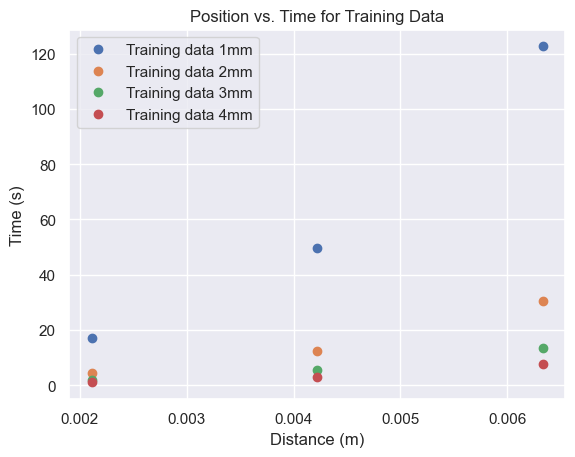

In [2]:
# Grab training data
dim_data = grab_training_data()

# Define legends for dimensionalized data
dim_legend = ['Training data 1mm', 'Training data 2mm', 'Training data 3mm', 'Training data 4mm']

# Functions to plot dimensionalized and nondimensionalized data
def plot_dim_data(show=True):
    for i in range(0, len(dim_data)):
        plt.plot(dim_data[i]['DISTANCE'], dim_data[i]['TIME'], 'o')
    plt.legend(dim_legend)
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (m)')
    plt.title('Position vs. Time for Training Data')
    if show:
        plt.show()

# Plot dimensionalized training data
plot_dim_data()

# Run the Model

Losses for 1mm droplet:
Epoch 1/50000, data loss: 5921624.5, physics loss: 39550730240.0
Epoch 2/50000, data loss: 5921402.0, physics loss: 39550730240.0
Epoch 3/50000, data loss: 5921179.5, physics loss: 39550730240.0
Epoch 4/50000, data loss: 5920957.0, physics loss: 39550730240.0
Epoch 5/50000, data loss: 5920734.0, physics loss: 39550730240.0
Epoch 6/50000, data loss: 5920508.5, physics loss: 39550730240.0
Epoch 7/50000, data loss: 5920282.5, physics loss: 39550726144.0
Epoch 8/50000, data loss: 5920054.5, physics loss: 39550726144.0
Epoch 9/50000, data loss: 5919825.5, physics loss: 39550726144.0
Epoch 10/50000, data loss: 5919594.0, physics loss: 39550726144.0
Epoch 5000/50000, data loss: 94222376.0, physics loss: 49208540.0
Epoch 10000/50000, data loss: 448790.53125, physics loss: 2300549.25
Epoch 15000/50000, data loss: 433969.6875, physics loss: 1839644.5
Epoch 20000/50000, data loss: 434646.5625, physics loss: 1629913.625
Epoch 25000/50000, data loss: 438438.5625, physics los

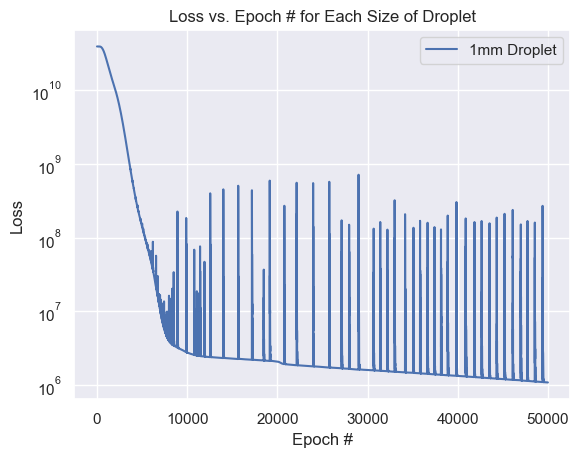

In [3]:
plt.yscale('log')
different_droplet_networks = [None] * len(dim_data)

'''
Train model for each droplet size, plot losses for each one.
Change the bounds on this loop and subsequent ones from '0', 'len(different_droplet_networks)' to '0', '1' to do only the 1mm droplet.
You can change the bounds similarly to only train the network for other-sized droplets.
'''
# for i in range(0, len(different_droplet_networks)):
for i in range(0, 1):
    different_droplet_networks[i] = Net(1, 1, droplet_size_idx=i, loss2=physics_loss_dim, epochs=50000, loss1_weight=1000, loss2_weight=1, lr=1e-4).to(DEVICE)
    print(f'Losses for {i+1}mm droplet:')
    losses = different_droplet_networks[i].fit(np.array(dim_data[i]['DISTANCE']), np.array(dim_data[i]['TIME']))
    print()
    plt.plot(losses)
plt.legend(['1mm Droplet', '2mm Droplet', '3mm Droplet', '4mm Droplet'])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch # for Each Size of Droplet')
plt.show()

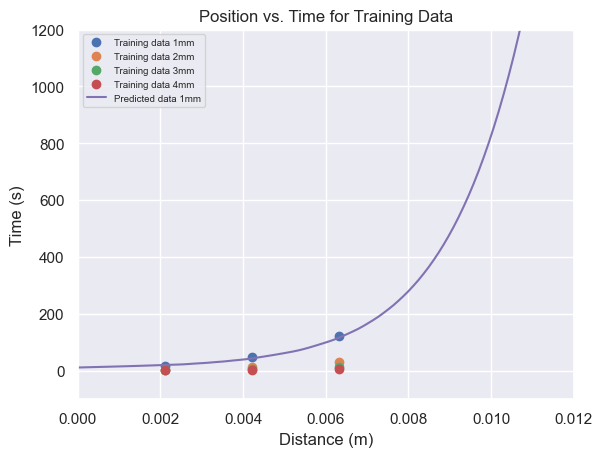

In [4]:
'''
Plot the dimensionalized data for each droplet as well as each respective dimensionalized model
'''

# Plot dimensionalized data
plot_dim_data(show=False)

# Use nondimensionalized model to make prediction
xs = np.linspace(0, 0.012, 100)

# Plot dimensionalized model
# for i in range(0, len(different_droplet_networks)):
for i in range(0, 1):
    preds = different_droplet_networks[i].predict(xs)
    plt.plot(xs, 1.75*preds-50)
    dim_legend.append(f'Predicted data {i+1}mm')
plt.legend(dim_legend, fontsize=7)
plt.xlim(0, 0.012)
plt.ylim(-100, 1200)
plt.show()



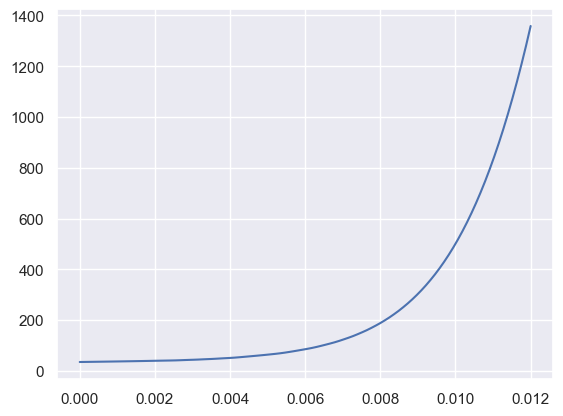

In [5]:
pred = different_droplet_networks[0].predict(xs)
plt.plot(xs, pred)
plt.show()